# Introduzione

## Descrizione del dataset
https://osf.io/vnbxk/overview
Il dataset analizza un campione di gamer internazionali e raccoglie informazioni psicologiche, demografiche e comportamentali.
Le variabili principali si suddividono in tre categorie:

Indicatori psicologici: risposte ai questionari GAD-7 (ansia), SPIN (fobia sociale) e SWL (soddisfazione di vita), da cui sono stati calcolati i punteggi totali GAD_T, SPIN_T e SWL_T.

Comportamento di gioco: informazioni su gioco preferito (Game), piattaforma (Platform), ore di gioco settimanali (Hours), motivazioni (whyplay), livello competitivo (highestleague) e stile di gioco (Playstyle).

Dati demografici: età (Age), genere (Gender), titolo di studio (Degree), occupazione (Work), paese di nascita e residenza.

La variabile target scelta per l’analisi è SWL_T (Satisfaction With Life Total Score), mentre le altre variabili vengono utilizzate come predittori nel modello di regressione.

### Fattori psicologici
GAD (Generalized Anxiety Disorder)
- GAD1 - GAD7: Individual question scores on the GAD-7 questionnaire
- GAD_T: Total GAD score (0–21)

SWL (Satisfaction With Life)
- SWL1 - SWL5: Individual question scores on the SWL questionnaire
- SWL_T: Total SWL score (5–35)

SPIN (Social Phobia Inventory)
- SPIN1 - SPIN17: Individual question scores on the SPIN questionnaire
- SPIN_T: Total SPIN score (0–68)


## Note
Il dataset è stato pubblicato il 30 ottobre 2017. Le modalità di gioco e le suddivisioni [ELO](https://it.wikipedia.org/wiki/Elo_(scacchi)) sono mutate nel corso degli anni. In questo documento si fa analisi considerando le suddivisioni di quando i dati sono stati raccolti.

# Cleanup del dataset

In [156]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dataset = pd.read_csv("GamingStudy_data.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   Timestamp        13464 non-null  float64
 2   GAD1             13464 non-null  int64  
 3   GAD2             13464 non-null  int64  
 4   GAD3             13464 non-null  int64  
 5   GAD4             13464 non-null  int64  
 6   GAD5             13464 non-null  int64  
 7   GAD6             13464 non-null  int64  
 8   GAD7             13464 non-null  int64  
 9   GADE             12815 non-null  object 
 10  SWL1             13464 non-null  int64  
 11  SWL2             13464 non-null  int64  
 12  SWL3             13464 non-null  int64  
 13  SWL4             13464 non-null  int64  
 14  SWL5             13464 non-null  int64  
 15  Game             13464 non-null  object 
 16  Platform         13464 non-null  object 
 17  Hours       

In [157]:
print("Numero di colonne con valori mancanti: ", dataset.isna().any().sum())
print("Numero di valori mancanti per colonna:")
dataset.isna().sum()[dataset.isna().sum() > 0]

Numero di colonne con valori mancanti:  30
Numero di valori mancanti per colonna:


GADE                 649
Hours                 30
League              1852
highestleague      13464
streams              100
SPIN1                124
SPIN2                154
SPIN3                140
SPIN4                159
SPIN5                166
SPIN6                156
SPIN7                138
SPIN8                144
SPIN9                158
SPIN10               160
SPIN11               187
SPIN12               168
SPIN13               187
SPIN14               156
SPIN15               147
SPIN16               147
SPIN17               175
Narcissism            23
Work                  38
Degree              1577
Reference             15
accept               414
SPIN_T               650
Residence_ISO3       110
Birthplace_ISO3      121
dtype: int64

La colonna 'highestleague' non contiene nessun valore quindi è possibile eliminarla. 'streams' non contiene valori utili ai fini dell'analisi

In [158]:
dataset.drop(columns=['highestleague', 'streams'], inplace=True)
dataset.dropna(subset=['SPIN_T'], inplace=True)
dataset.drop(['S. No.' , 'Timestamp'] , axis = 1 , inplace = True)

In [159]:
print("Elementi duplicati: ", dataset.duplicated().sum())
dataset = dataset.drop_duplicates()
print("Elementi duplicati dopo rimozione: ", dataset.duplicated().sum())

Elementi duplicati:  49
Elementi duplicati dopo rimozione:  0


### Scelta di gioco

In [160]:
print("Giochi distinti:", dataset['Game'].dropna().unique())
# counts for each value (shows NaN count if any)
print("\nConteggio dei valori per gioco (inclusi NaN):")
print(dataset['Game'].value_counts(dropna=False))

Giochi distinti: ['Skyrim' 'Other' 'World of Warcraft' 'League of Legends' 'Starcraft 2'
 'Counter Strike' 'Destiny' 'Diablo 3' 'Heroes of the Storm' 'Hearthstone'
 'Guild Wars 2']

Conteggio dei valori per gioco (inclusi NaN):
Game
League of Legends      10731
Other                    970
Starcraft 2              322
Counter Strike           298
World of Warcraft        149
Hearthstone               95
Diablo 3                  83
Heroes of the Storm       40
Guild Wars 2              36
Skyrim                    23
Destiny                   18
Name: count, dtype: int64


Il gioco dominante del dataset è *League of Legends*. Poiché le modalità di gioco (competitività, categoria...) influiscono sui fattori psicologici e la sproporzione di risposte non consenta un'analisi approfondita, si considera la sola valutazione dei dati relativi a *League of Legends*

In [161]:
lol_dataset = dataset[dataset['Game'] == 'League of Legends'].copy()

## Cleanup dei ranghi (League)

In [162]:
lol_dataset.League = lol_dataset.League.str.lower().str.strip()
# Prende la prima parola
lol_dataset["League"] = lol_dataset["League"].str.extract(r'^([a-z]+)')
print(lol_dataset["League"].value_counts().head(50))
print(lol_dataset["League"].nunique())


League
gold           2648
silver         1946
platinum       1556
diamond        1265
plat            503
bronze          466
unranked        455
master           81
platin           77
platinium        64
challenger       58
d                39
not              34
s                26
g                25
none             18
platnium         17
placements       15
i                12
currently        10
masters          10
p                10
dia               9
sliver            8
b                 8
challenjour       8
still             6
unraked           6
was               6
season            5
high              5
haven             5
platine           5
na                4
don               4
platium           4
no                4
league            3
placement         3
lol               3
golf              3
last              3
plarinum          3
wood              3
n                 3
peaked            2
bronce            2
platnum           2
in                2
got          

In [163]:
golds = ['g', 'gv', 'golden' ,'glod' ,'golld' ,'golf', 'goled', 'golderino' ,'giii']
lol_dataset['League'] = lol_dataset.League.replace(golds , 'gold')
silvers = [ 'silverii' , 's' , 'sliver' , 'siver' , 'silber' , 'sil' , 'silveriv']
lol_dataset['League'] = lol_dataset.League.replace(silvers , 'silver')
plats = [
    'platinium' , 'platnium' , 'platin' ,'pplatinum' ,'plarinum' ,'platium', 'p' ,'platine' ,
    'platinun' ,'platonum' ,'platnum', 'plata' ,'plantinum',
    'platinuim' ,'platunum', 'plantinum' ,'platunum' ,'platinumm' ,'platv' ,'platina' , 'plat' 
]
lol_dataset['League'] = lol_dataset.League.replace(plats , 'platinum')
bronzers = ['bronce' , 'b' , 'broze' ,'lowest' , 'wood', 'elohell'] 
lol_dataset['League'] = lol_dataset.League.replace(bronzers , 'bronze')
unranked = ['none' ,'na', 'not' ,'n' ,'promos' ,'provisional' ,'placements' , 'dont' , 'was', 'unraked',
            'havent', 'never', 'nope', 'no', 'noone', 'don', 'of', 'unrranked', 'new', 'what', 'unrank' ,
            'ranked', 'placement', 'unrankt' , 'non', 'unfranked' , 'promotion', 'idk',
            'unplaced', 'probably', 'provisionals', 'didnt' ,'unrakned' , 'unfinished' , 'just' , 'x' ,
            'promotions' , 'unseeded' , 'haven', 'uwot', 'spanish', 'around', 'finishing', 'ahgl','i', 'currently', 'still', 'high', 'season', 'lol', 'last', 'league', 'got', 'the', 'peaked', 'in', 'atm', 'were', 'ex', 'finished', 'will', 'climbing', 'yes', 'csgo', 'unable', 'under', 'having', 'if', 'level', 'lissandra', 'north', 'low', 'ended', 'doing', 'pre', 'zilean', 'aram', 'lvl', 'current', 'first', 'recently', 'challenged', 'soloq', 'cardboard', 'seaon', 'almost', 'legendary', 'german', 'placed', 'un', 'eu', 'qualifiying', 'euw']
lol_dataset['League'] = lol_dataset.League.replace(unranked , 'unranked')
diamonds =  ['d', 'dia', 'diaomnd', 'diamont','diamomd']
lol_dataset['League'] = lol_dataset.League.replace(diamonds , 'diamond')
gm =  ['grand', 'gm', 'grandmasters']
lol_dataset['League'] = lol_dataset.League.replace(gm , 'grandmaster')
chall =  ['challenjour', 'c', 'charrenjour', 'challeneger']
lol_dataset['League'] = lol_dataset.League.replace(chall , 'challenger')
lol_dataset['League'] = lol_dataset['League'].replace('masters', 'master') 
lol_dataset.League.value_counts()
# Elimino i valori mancanti


League
gold          2683
platinum      2249
silver        1984
diamond       1315
unranked       682
bronze         482
master          91
challenger      68
Name: count, dtype: int64

In [164]:
# lol_dataset.dropna(subset=['GADE'], inplace=True)
# lol_dataset.dropna(subset=['Hours'], inplace=True)
# lol_dataset.dropna(subset=['Work'], inplace=True)

In *League of Legends* i giocatori possono scegliere di giocare partite **competitive** o **normali**. Nelle competitive viene misurato il rank/rango che è il valore colonna 'League' nel dataset. Questo assume valori da Bronze (minimo) a Challenger (massimo). Si assegnano quindi valori da 1-7 per indicare esso. Il valore 0 indica senza rango.

In [165]:
league_order = {
    'unranked': 0,
    'bronze': 1,
    'silver': 2,
    'gold': 3,
    'platinum': 4,
    'diamond': 5,
    'master': 6,
    'challenger': 7,
}

lol_dataset['League_num'] = lol_dataset['League'].map(league_order)

# Analisi esplorativa (EDA - Exploratory Data Analysis)

In [166]:
pd.set_option('display.max_columns', None)
lol_dataset.describe()

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,SWL1,SWL2,SWL3,SWL4,SWL5,Hours,SPIN1,SPIN2,SPIN3,SPIN4,SPIN5,SPIN6,SPIN7,SPIN8,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,Narcissism,Age,GAD_T,SWL_T,SPIN_T,League_num
count,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.00000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10708.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10723.000000,10731.000000,10731.000000,10731.000000,10731.000000,9554.000000
mean,0.857888,0.667971,0.968409,0.717081,0.482527,0.91436,0.584568,3.723232,4.610474,4.353648,3.761252,3.354673,22.163709,0.861989,1.220296,1.084987,1.678222,1.244246,1.345448,1.053304,1.389992,1.553816,0.909514,1.821825,0.887522,0.529587,1.247694,1.404995,0.617929,0.934489,2.023687,20.829093,5.192806,19.803280,19.785854,3.045007
std,0.922348,0.912274,0.982147,0.918945,0.834567,0.92799,0.891923,1.730274,1.684693,1.800821,1.820621,1.913461,78.247808,0.904715,1.143042,1.164659,1.223790,1.216263,1.275127,1.222327,1.366790,1.380589,1.122968,1.482653,1.152542,0.932651,1.205054,1.347114,0.958579,1.182386,1.059417,3.154525,4.681088,7.193036,13.424734,1.426765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,5.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,3.000000,3.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,2.000000,14.000000,9.000000,2.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,4.000000,5.000000,5.000000,4.000000,3.000000,20.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,20.000000,4.000000,20.000000,17.000000,3.000000
75%,1.000000,1.000000,2.000000,1.000000,1.000000,1.00000,1.000000,5.000000,6.000000,6.000000,5.000000,5.000000,28.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,3.000000,22.000000,8.000000,25.000000,28.000000,4.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,8000.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,56.000000,21.000000,35.000000,68.000000,7.000000


## Outlier
Dal describe della tabella precedente è possibile notare che la colonna Hours assume un valore massimo di 8000 ore. Questo è errato poiché la colonna indica il numero di ore giocate in una settimana, il cui massimo teorico è 168 ore. Si decide quindi di tenere i valori realistici, assumendo il massimo come 75% del numero totale di ore in settimana.

In [167]:
lol_dataset = lol_dataset[lol_dataset['Hours'] <= 0.75 * 168]

## Distribuzioni

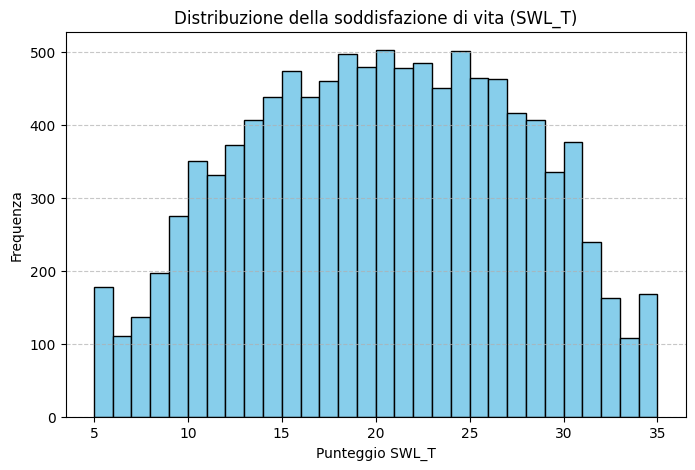

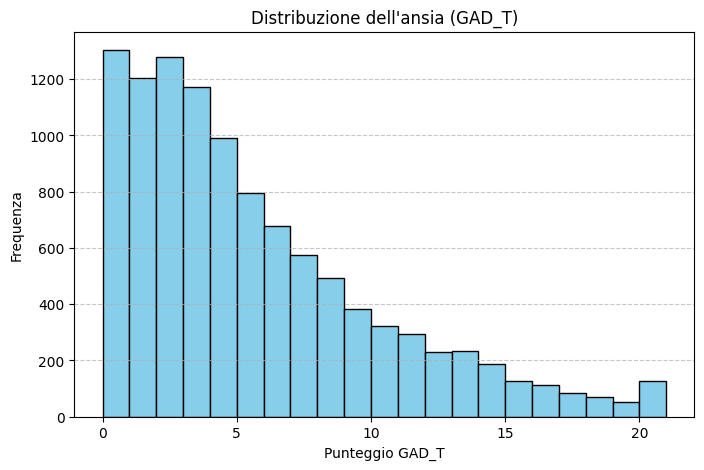

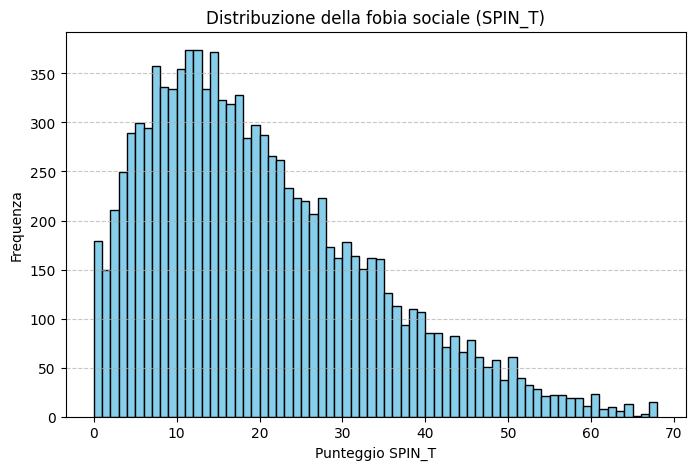

In [168]:
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['SWL_T'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione della soddisfazione di vita (SWL_T)')
plt.xlabel('Punteggio SWL_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['GAD_T'], bins=21, color='skyblue', edgecolor='black')
plt.title('Distribuzione dell\'ansia (GAD_T)')
plt.xlabel('Punteggio GAD_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['SPIN_T'], bins=68, color='skyblue', edgecolor='black')
plt.title('Distribuzione della fobia sociale (SPIN_T)')
plt.xlabel('Punteggio SPIN_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La variabile target SWL_T presenta una distribuzione approssimativamente normale, centrata intorno ai valori medi. Ciò suggerisce che il campione è bilanciato e che i modelli di regressione lineare sono appropriati per la predizione del livello di soddisfazione di vita.

Distribuzione delle League

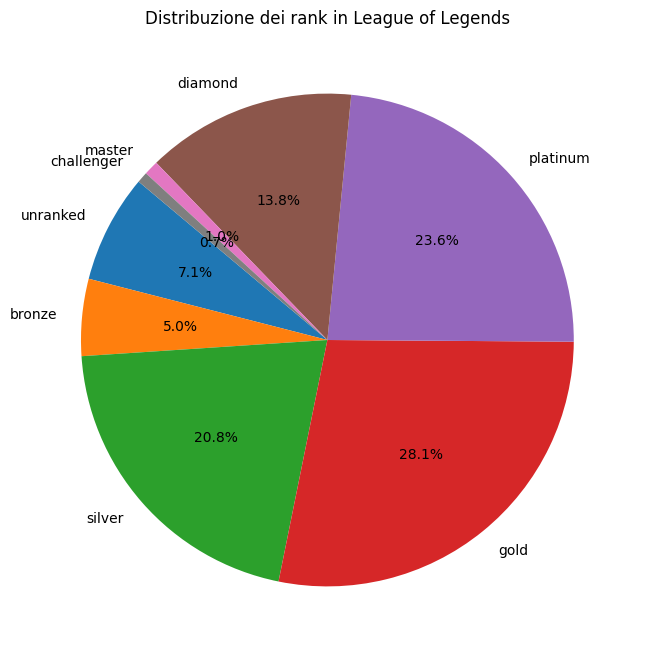

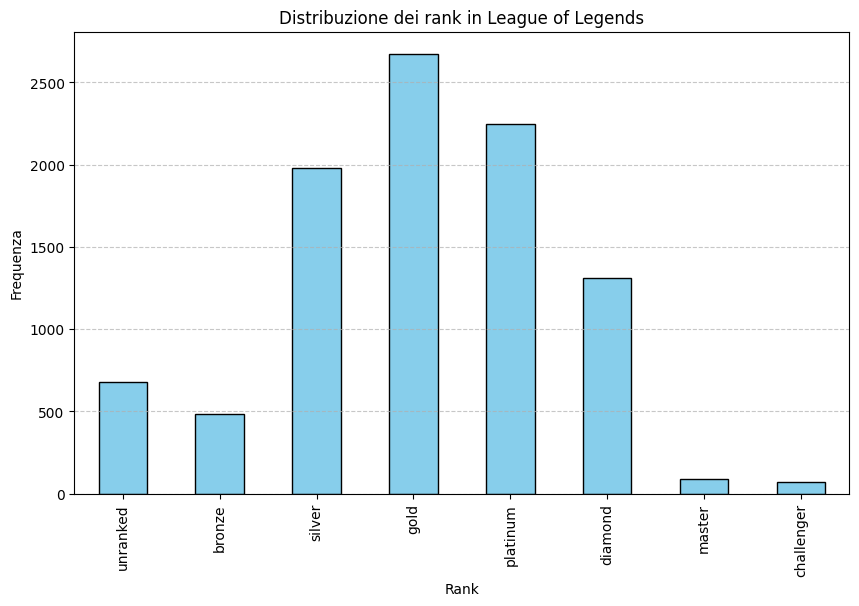

In [169]:
league_counts = lol_dataset['League'].value_counts().sort_index(key=lambda x: x.map(league_order))
league_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8,8))
plt.title('Distribuzione dei rank in League of Legends')
plt.ylabel('')
plt.show()
league_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,6))
plt.title('Distribuzione dei rank in League of Legends')
plt.xlabel('Rank')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Il grafico mostra che i livelli di competitività più alti hanno meno frequenza e che in media i giocatori di questo dataset si trovano tra silver, gold e platinum.

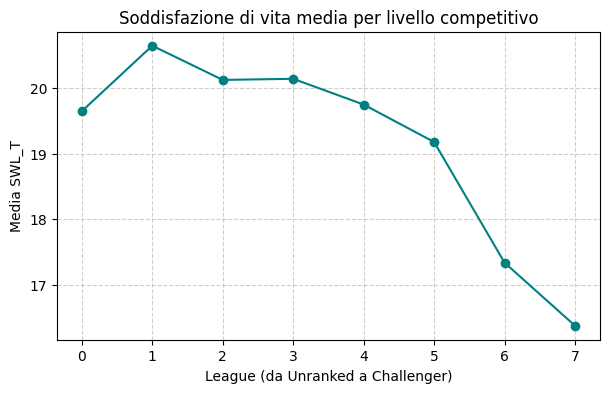

In [170]:
avg_swl = lol_dataset.groupby('League_num')['SWL_T'].mean()

plt.figure(figsize=(7,4))
plt.plot(avg_swl.index, avg_swl.values, marker='o', color='teal')
plt.title('Soddisfazione di vita media per livello competitivo')
plt.xlabel('League (da Unranked a Challenger)')
plt.ylabel('Media SWL_T')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Dal grafico si può notare che la soddisfazione di vita decresce all'aumentare del rank

## Correlazioni

<Axes: >

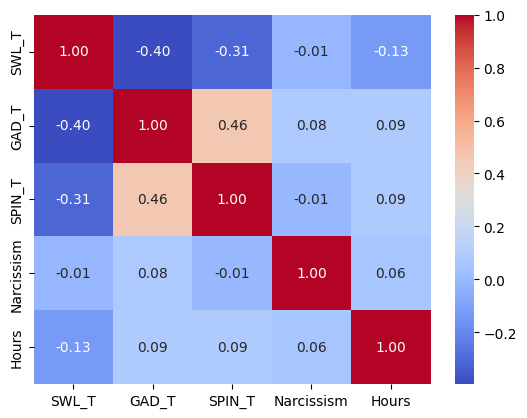

In [171]:
val = ['SWL_T', 'GAD_T', 'SPIN_T', 'Narcissism', 'Hours']

corr_matrix = lol_dataset[val].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")